# YOLOv8 Trial
## Prediction
https://docs.ultralytics.com/modes/predict/#inference-sources

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
from IPython.display import display, Image

In [4]:
!nvidia-smi

Thu Jun  6 03:24:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   40C    P2              81W / 300W |  13657MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
current_directory = os.getcwd()
print(current_directory)

DATA_DIR = "/mnt/nfs_p/yolo/trial/gorilla"

os.chdir(DATA_DIR)
current_directory = os.getcwd()
print(current_directory)

/mnt/code/umineko-seg-dev/notebooks
/mnt/nfs_p/yolo/trial/gorilla


## Original image data

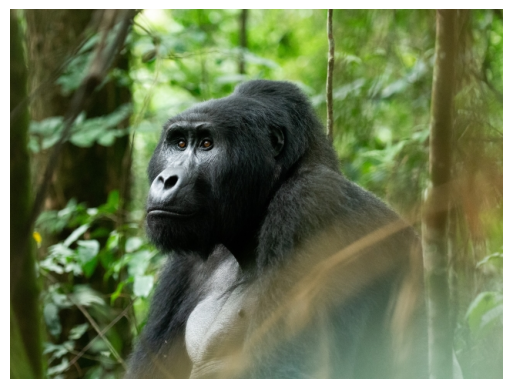

In [6]:
IMG_PATH = f"{DATA_DIR}/DSC_4776_Kanyonyi_640_480.jpg"
image_path = f'{DATA_DIR}/DSC_4776_Kanyonyi_640_480.jpg'
image = cv2.imread(image_path)
plt.figure(figsize=(6.4, 4.8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.close()

## Run inference using pretrained model

In [7]:
# Load a model
WEIGHTS_PATH = "yolov8s-seg.pt"
model = YOLO(WEIGHTS_PATH)  # load a pretrained model (recommended for training)

# Run inference on the source
results = model.predict(IMG_PATH, save=False, imgsz=640, conf=0.5)
# results = model.predict(IMG_PATH, save=True, imgsz=640, conf=0.5)


image 1/1 /mnt/nfs_p/yolo/trial/gorilla/DSC_4776_Kanyonyi_640_480.jpg: 480x640 1 bear, 102.1ms
Speed: 2.0ms preprocess, 102.1ms inference, 365.5ms postprocess per image at shape (1, 3, 480, 640)


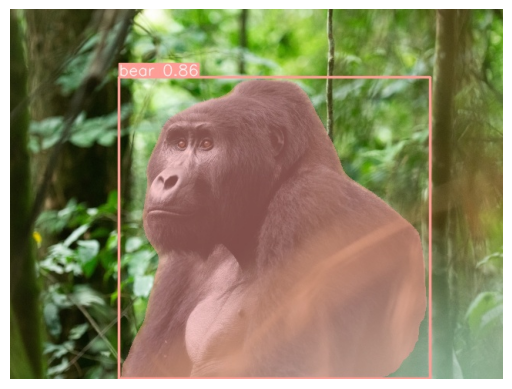

In [8]:
# Show prediction results
plt.figure(figsize=(6.4, 4.8))
_image_path = f'{DATA_DIR}/runs/segment/predict/DSC_4776_Kanyonyi_640_480.jpg'
_image = cv2.imread(_image_path)
plt.imshow(cv2.cvtColor(_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Fetch mask data from results

In [13]:
def create_masked_image(results, image):

    # マスクデータの取得
    masks = results[0].masks  # 最初の結果からマスクを取得
    num_masks = masks.shape[0]  # マスクの数
    mask_height, mask_width = masks.shape[1], masks.shape[2]
    
    # 特定のマスクを選択
    selected_mask_index = 0
    # selected_mask_index = 1
    # selected_mask_index = 2
    selected_mask = masks.data[selected_mask_index]
    
    # マスクをnumpy配列に変換
    if isinstance(selected_mask, torch.Tensor):
        selected_mask = selected_mask.cpu().numpy()
    
    # マスクを元の画像サイズにリサイズ
    resized_mask = cv2.resize(selected_mask, (image.shape[1], image.shape[0]))
    
    # 一つ目のクラスとして認識されたピクセルの数をカウント
    # 閾値を0.5として、ピクセルが1に近い部分をカウント
    pixel_count = np.sum(resized_mask > 0.5)
    print(f"Number of pixels in the class {selected_mask_index}: {pixel_count:,} ({pixel_count/(image.shape[1]*image.shape[0])*100:.1f}%)")
    
    # 色
    color = [255, 255, 0]  # シアン色に設定
    # color = [255, 0, 255]  # マゼンタ色に設定
    # color = [0, 255, 255]  # イエロー色に設定
    # color = [0, 255, 0]  # 緑色に設定
    
    # color = np.array([0, 159, 230])  # オレンジ色に設定
    # color = np.array([233, 180, 86])  # 水色に設定
    # color = np.array([115, 158, 0])  # 緑色に設定
    # color = np.array([66, 228, 240])  # 黄色に設定
    # color = np.array([178, 114, 0])  # 青色に設定
    # color = np.array([0, 94, 213])  # 赤茶色に設定
    color = np.array([167, 121, 204])  # ピンク色に設定
    
    # 透明度
    alpha = 0.5  # 透明度を設定（0.0から1.0の間の値）
                
    # カラーを適用
    masked_image = image.copy()
    for c in range(3):  # 3チャンネル分（RGB）を設定
        masked_image[:, :, c] = np.where(
            resized_mask > 0.5, 
            (1 - alpha) * masked_image[:, :, c] + alpha * color[c] * (resized_mask > 0.5), 
            masked_image[:, :, c]
        )
    
    # 結果の表示
    fig = plt.figure(figsize=(6.4, 4.8))
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    plt.close()
    
    return fig

Number of pixels in the class 0: 114,585 (37.3%)


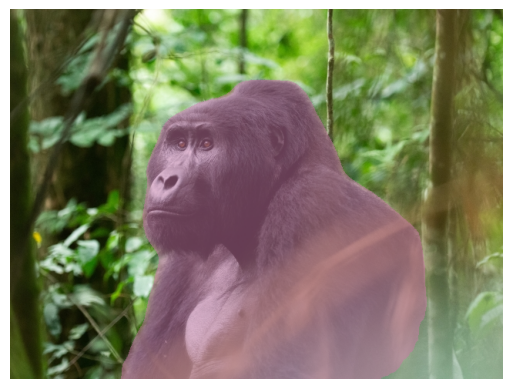

In [14]:
fig = create_masked_image(results, image)

In [74]:
results[0].boxes.xyxy

tensor([[141.4002,  88.3677, 545.4374, 479.0801]], device='cuda:0')

In [75]:
results[0].boxes.conf

tensor([0.8590], device='cuda:0')

In [76]:
results[0].boxes.cls

tensor([21.], device='cuda:0')

In [81]:
print(results[0].masks.shape)
print(results[0].masks[0].shape)
print(results[0].masks.data.shape)
print(results[0].masks.data[0].shape)

torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
torch.Size([480, 640])
